# Import Core Libraries

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

from os import listdir, walk
from os.path import isfile, join

# Load Dataset

In [54]:
%run load_dataset.ipynb

Loading 1001's data
Loading 1002's data
Loading 1003's data
Loading 1004's data
Loading 1005's data
Loading 1006's data
Loading 1007's data
Loading 1008's data
Loading 2001's data
Loading 2002's data
Finished loading


# Data Preprocessing

In [346]:
%run preprocess_for_SVM.ipynb
# includes wavelet denoising, normalization, PCA, LDA, SVD, etc.

In [331]:
print(X_all.shape, y_all.shape)

(19931, 3) (19931,)


# Group Data by Label and Normalize Data *

In [275]:
print(label_list)

['downstairs', 'sit', 'sleep', 'stand', 'upstairs', 'walk']


In [57]:
# denoise the signal using wavelet transform
# wavelet_output = wavelet_smooth(X_all)
# X_w = np.array(wavelet_output)

In [59]:
new_label_list = [1,2,3,0,4,5]
new_label_dict = {
    1: 'sit',
    2: 'sleep',
    3: 'stand',
    0: 'downstairs',
    4: 'upstairs',
    5: 'walk'
}

colors = ['r','g','b','navy','turquoise','darkorange']

In [332]:
# group X_all and y_all from load_dataset.ipynb by labels
X_label, y_label = label_grouping(X_all, y_all, subj_all, new_label_list)

# normalize X_label
X_norm = normalize_data(X_label)

## Show Plot for each Activity and Subject

plotting  sit


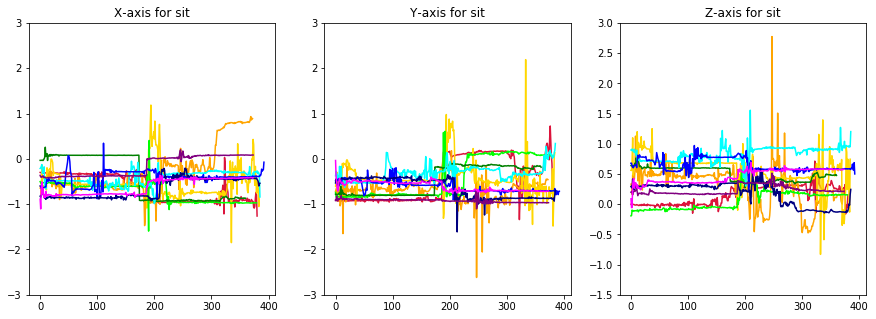

plotting  sleep


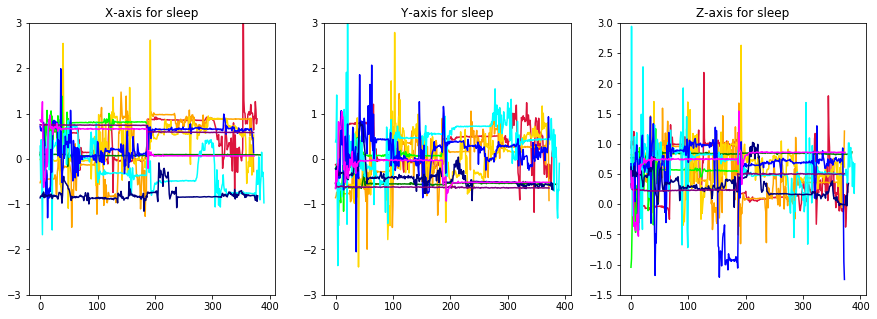

plotting  stand


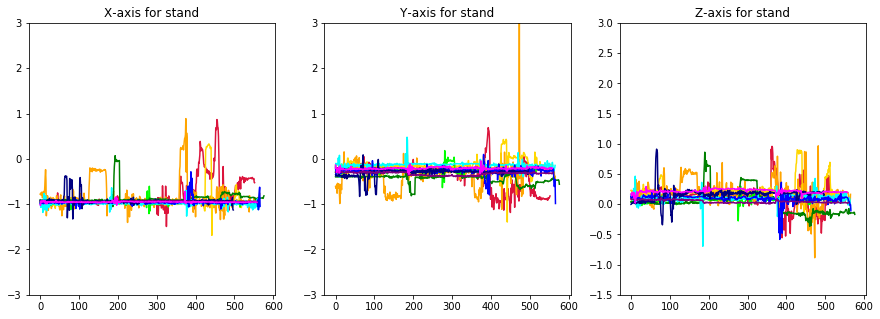

plotting  downstairs


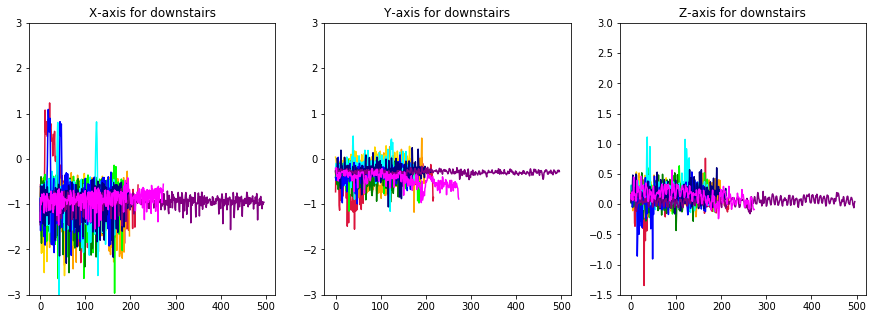

plotting  upstairs


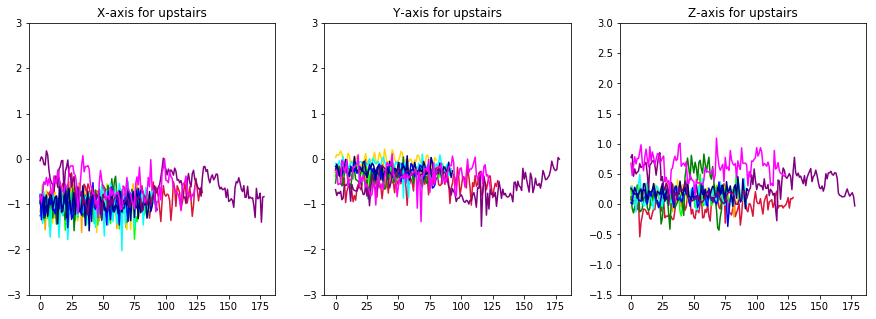

plotting  walk


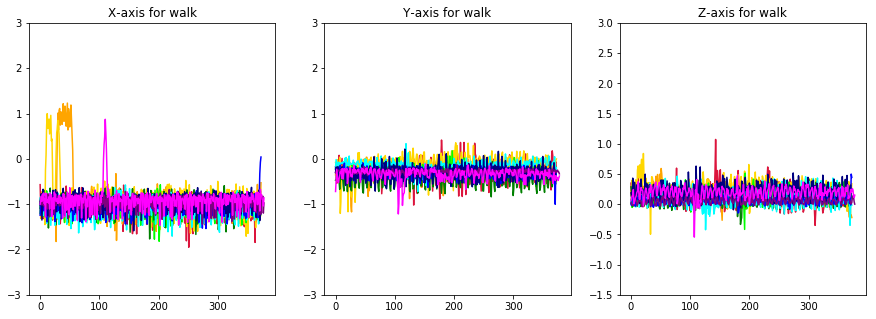

In [347]:
plot_all_label(X_label, y_all, new_label_list, new_label_dict)

# Calculate Roll, Pitch, Yaw

In [274]:
roll, pitch, yaw = calc_rpy(X_all, subject_id, colors)
rpy = np.array([roll, pitch, yaw]).transpose()

print(rpy.shape)

(19931, 3)


# Apply PCA and LDA

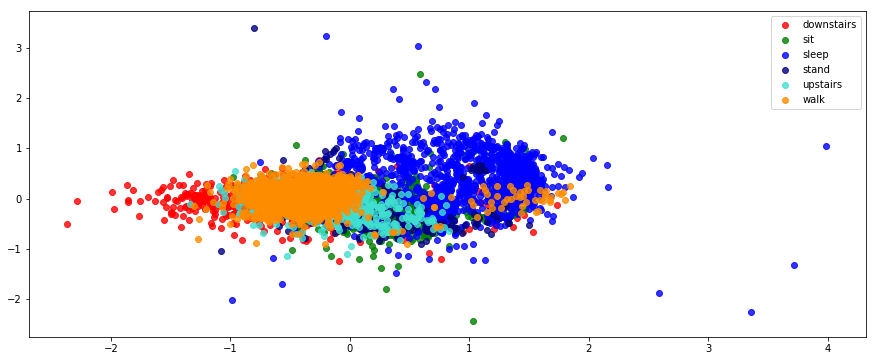

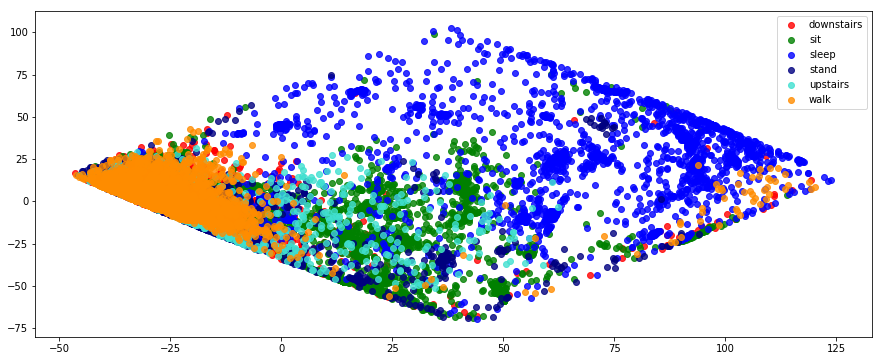

In [168]:
# apply PCA and LDA to X_norm and rpy
X_pca = apply_pca(X_all, y_all, label_list)
rpy_pca = apply_pca(rpy, y_all, label_list)

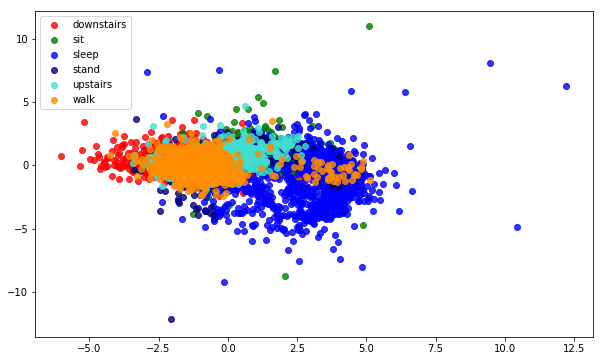

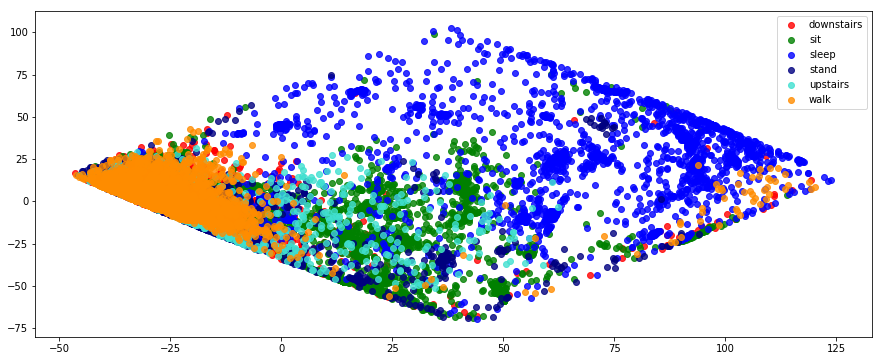

In [98]:
X_lda = apply_lda(X_all, y_all, label_list)
rpy_lda = apply_pca(rpy, y_all, label_list)

# Reshape Data (Pure Label)

In [248]:
def prepare_pure_label(X, y, subj_all, new_label_list):
    X_label, y_label = label_grouping(X, y, subj_all, new_label_list)
    
    X_concat = []
    y_concat = []
    for i in range(len(X_label)):
        for j in range(len(X_label[i])):
            X_ol, y_ol = make_overlapping(np.array(X_label[i][j]), y_label[i][j])

            if(len(X_concat)==0):
                X_concat = X_ol
            else:
                X_concat = np.vstack((X_concat, X_ol))

            if(len(y_concat)==0):
                y_concat = y_ol
            else:
                y_concat = np.hstack((y_concat, y_ol))
    
    X_concat_xyz = concat_xyz(X_concat)
    
    return X_concat_xyz, y_concat    

In [250]:
# get label-separated X and y
X_svm, y_svm = prepare_pure_label(X_lda, y_all, subj_all, new_label_list)
y_svm = y_svm.reshape((y_svm.shape[0],))

In [251]:
print(X_svm.shape, y_svm.shape)

(16391, 180) (16391,)


# Reshape Data (Impure Label)

In [259]:
def prepare_impure_label(X, y):
    X_ol, y_ol = make_overlapping(X, y)
    X_concat_ol = concat_xyz(X_ol)
    
    return X_concat_ol, y_ol

In [260]:
X_impure, y_impure = prepare_impure_label(X_lda, y_all)

In [261]:
print(X_impure.shape, y_impure.shape)

(19872, 180) (19872,)


# Split Train and Test Set

In [265]:
# Split training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X_svm, y_svm, test_size=0.3, random_state=42)

X_tr, X_te, y_tr, y_te = train_test_split(X_impure, y_impure, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)

(11473, 180)
(4918, 180)


# SVM

In [311]:
svm_model = svm_classifier(X_train, y_train)
print("Finished training")

Finished training


In [312]:
y_pred_svm = svm_model.predict(X_test)

## SVM Evaluation

In [313]:
%run eval_score.ipynb

In [314]:
LABELS = ['downstairs','sit','sleep','stand','upstairs','walk']

0.8906059373729158


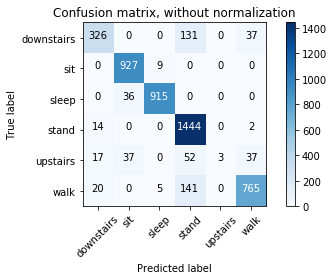

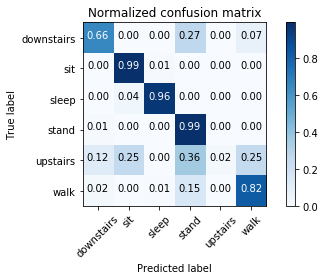

              precision    recall  f1-score   support

  downstairs       0.86      0.66      0.75       494
         sit       0.93      0.99      0.96       936
       sleep       0.98      0.96      0.97       951
       stand       0.82      0.99      0.89      1460
    upstairs       1.00      0.02      0.04       146
        walk       0.91      0.82      0.86       931

   micro avg       0.89      0.89      0.89      4918
   macro avg       0.92      0.74      0.75      4918
weighted avg       0.90      0.89      0.88      4918



In [315]:
acc = accuracy_score(y_test, y_pred_svm)
print(acc)

show_conf_matrix(y_test, y_pred_svm, LABELS)
show_clf_report(y_test, y_pred_svm, LABELS)

# K-NN

In [316]:
nn_model = nn_classifier(X_train, y_train)
print("Finished training")

Finished training


In [317]:
y_pred_nn = nn_model.predict(X_test)

## K-NN Evaluation

0.8251321675477836


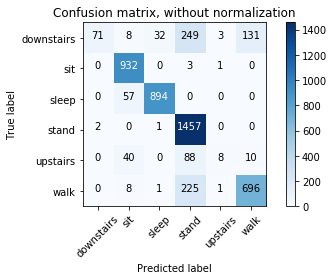

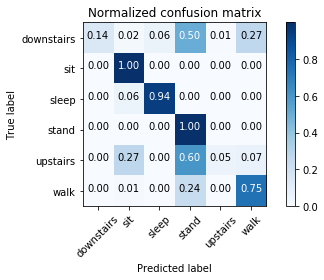

              precision    recall  f1-score   support

  downstairs       0.97      0.14      0.25       494
         sit       0.89      1.00      0.94       936
       sleep       0.96      0.94      0.95       951
       stand       0.72      1.00      0.84      1460
    upstairs       0.62      0.05      0.10       146
        walk       0.83      0.75      0.79       931

   micro avg       0.83      0.83      0.83      4918
   macro avg       0.83      0.65      0.64      4918
weighted avg       0.84      0.83      0.79      4918



In [318]:
acc = accuracy_score(y_test, y_pred_nn)
print(acc)

show_conf_matrix(y_test, y_pred_nn, LABELS)
show_clf_report(y_test, y_pred_nn, LABELS)

# Walk Algorithm

In [357]:
%run classifier_alg.ipynb

In [358]:
# classify walking
walk = calc_walk(X_all)
walk_its = intersection_walk(walk)
walk_pred_p = calc_walk_periods(walk_its)

walk_exact_p = get_exact_walk(y_all)
    
walk_pred = binarize_walk_prd(walk_pred_p, y_all)
walk_exact = binarize_walk_prd(walk_exact_p, y_all)

In [355]:
for w in walk_pred_p:
    print(w.s, w.f)
    
for w in walk_exact_p:
    print(w.s, w.f)

0 110
130 210
1530 1700
1720 2030
2080 2190
3400 3460
3540 4000
4020 4170
5490 5950
6050 6130
7220 7340
7360 7700
9140 9700
9720 9770
11110 11590
11610 11750
12150 12210
13080 13410
13430 13490
13510 13590
13630 13730
15010 15330
15350 15480
15500 15580
15640 15690
15750 15810
15830 15850
15880 15910
17290 17340
17450 17590
17610 17760
17780 17800
17820 17890
17910 18120
19420 19570
19590 19920
0 217
1531 2233
3546 4175
5494 6136
7220 7821
9146 9768
11112 11753
13087 13753
15018 15981
17289 18120


## Walk Algorithm Evaluation

In [351]:
walk_lbl = ['NaN','walk']

0.9216797952937635


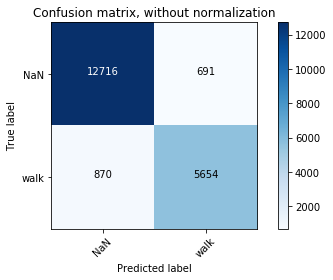

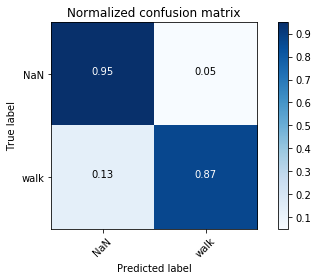

              precision    recall  f1-score   support

         NaN       0.94      0.95      0.94     13407
        walk       0.89      0.87      0.88      6524

   micro avg       0.92      0.92      0.92     19931
   macro avg       0.91      0.91      0.91     19931
weighted avg       0.92      0.92      0.92     19931



In [359]:
acc = accuracy_score(walk_exact, walk_pred)
print(acc)

show_conf_matrix(walk_exact, walk_pred, walk_lbl)
show_clf_report(walk_exact, walk_pred, walk_lbl)

# Combine SVM and Walk Algorithm

In [319]:
X_walk = [X_all[i] for i in range(len(walk_pred)) if walk_pred[i]==1]
X_non_walk = [X_all[i] for i in range(len(walk_pred)) if walk_pred[i]==0]

X_walk = np.array(X_walk)
X_non_walk = np.array(X_non_walk)

y_walk = [y_all[i] for i in range(len(walk_pred)) if walk_pred[i]==1]
y_non_walk = [y_all[i] for i in range(len(walk_pred)) if walk_pred[i]==0]

y_walk = np.array(y_walk)
y_non_walk = np.array(y_non_walk)

In [320]:
print(X_walk.shape, X_non_walk.shape)
print(y_walk.shape, y_non_walk.shape)

(6711, 3) (13220, 3)
(6711,) (13220,)


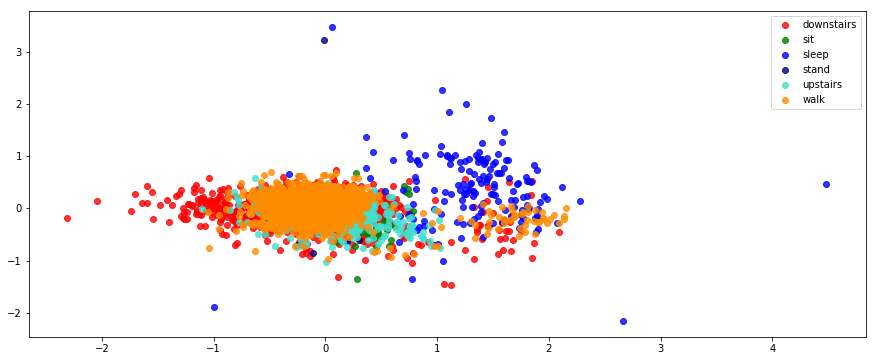

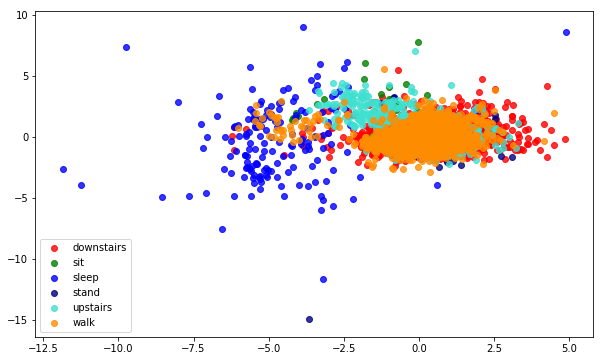

In [321]:
Xw_pca = apply_pca(X_walk, y_walk, label_list)
Xw_lda = apply_lda(X_walk, y_walk, label_list)

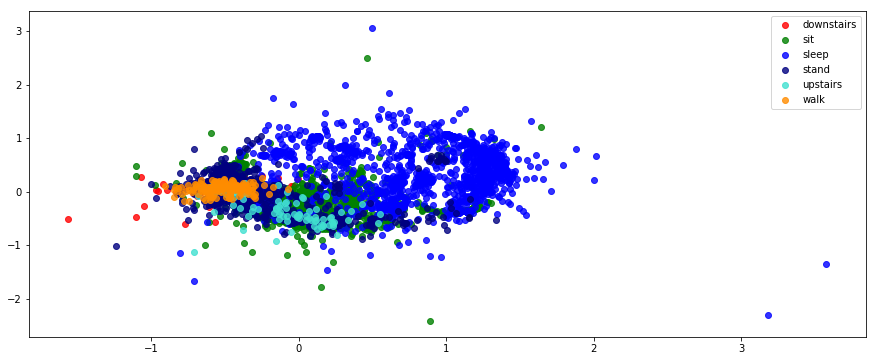

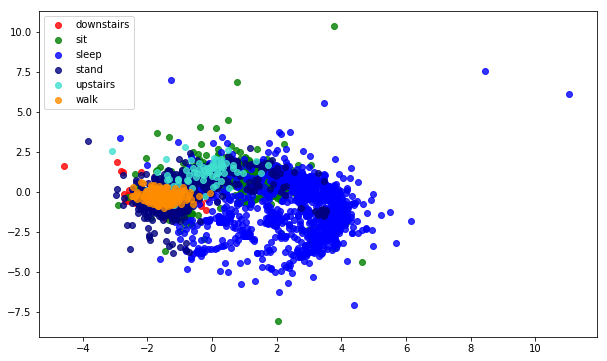

In [322]:
Xnw_pca = apply_pca(X_non_walk, y_non_walk, label_list)
Xnw_lda = apply_lda(X_non_walk, y_non_walk, label_list)

In [297]:
Xw_train, Xw_test, yw_train, yw_test = train_test_split(Xw_lda, y_walk, test_size=0.3, random_state=42)

Xnw_train, Xnw_test, ynw_train, ynw_test = train_test_split(Xnw_lda, y_non_walk, test_size=0.3, random_state=42)

In [323]:
svm_walk = svm_classifier(Xw_train, yw_train)
print("Finish Training")

Finish Training


In [324]:
svm_non_walk = svm_classifier(Xnw_train, ynw_train)
print("Finish Training")

Finish Training


In [325]:
yw_pred = svm_walk.predict(Xw_test)
ynw_pred = svm_non_walk.predict(Xnw_test)

0.6459781529294936


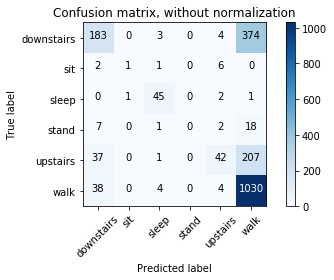

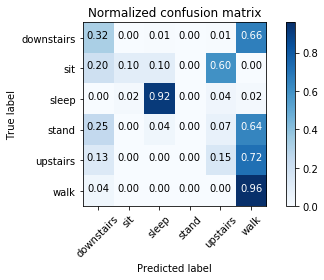

              precision    recall  f1-score   support

  downstairs       0.69      0.32      0.44       564
         sit       0.50      0.10      0.17        10
       sleep       0.82      0.92      0.87        49
       stand       0.00      0.00      0.00        28
    upstairs       0.70      0.15      0.24       287
        walk       0.63      0.96      0.76      1076

   micro avg       0.65      0.65      0.65      2014
   macro avg       0.56      0.41      0.41      2014
weighted avg       0.65      0.65      0.59      2014



c:\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [326]:
acc = accuracy_score(yw_test, yw_pred)
print(acc)

show_conf_matrix(yw_test, yw_pred, LABELS)
show_clf_report(yw_test, yw_pred, LABELS)

0.872667675239536


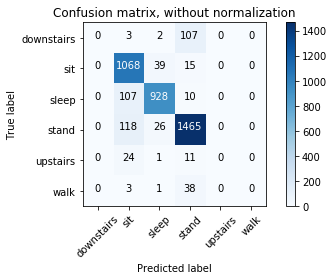

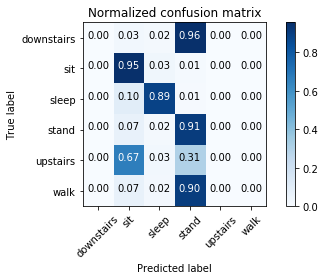

              precision    recall  f1-score   support

  downstairs       0.00      0.00      0.00       112
         sit       0.81      0.95      0.87      1122
       sleep       0.93      0.89      0.91      1045
       stand       0.89      0.91      0.90      1609
    upstairs       0.00      0.00      0.00        36
        walk       0.00      0.00      0.00        42

   micro avg       0.87      0.87      0.87      3966
   macro avg       0.44      0.46      0.45      3966
weighted avg       0.83      0.87      0.85      3966



c:\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [327]:
acc = accuracy_score(ynw_test, ynw_pred)
print(acc)

show_conf_matrix(ynw_test, ynw_pred, LABELS)
show_clf_report(ynw_test, ynw_pred, LABELS)

# Combine SVM and Walk Algorithm (v2)

In [290]:
print(y_pred_svm)

[1 5 3 ... 1 1 2]


# Note

Window Length : Accuracy

40 : 0.9016

30 : 0.9271

5 : 0.9898